# Analysis of Chest X-Ray images

The objective of this exercise is to identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image.

This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".


In [180]:
import keras
import tensorflow as tf
from skimage import io
import os
import glob
import numpy as np


import warnings
warnings.simplefilter('ignore')

from keras.applications import mobilenet
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

In [181]:
DATASET_PATH = './CXR_data'

## data src : https://www.kaggle.com/nih-chest-xrays

# There are two classes of images that we will deal with
disease_cls = ['effusion', 'nofinding']

Next, we read the "effusion" and "nofinding" images.

len of effusion samples:107
len of normal samples:1000
shape of each image : (1024, 1024)
shape of each image : (1024, 1024)


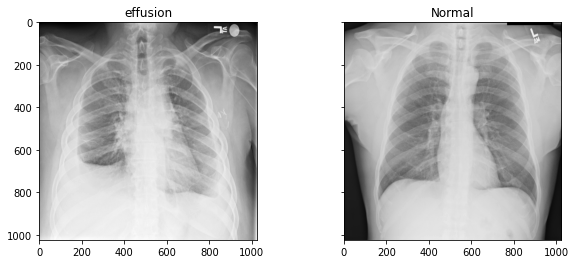

In [182]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusionfilepath = glob.glob(effusion_path)
print('len of effusion samples:{}'.format(len(effusionfilepath)))
effusion_img = io.imread(effusionfilepath[0]) #take one sample image file

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normalfilepath = glob.glob(normal_path)
print('len of normal samples:{}'.format(len(normalfilepath)))
normal_img = io.imread(normalfilepath[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].imshow(effusion_img, cmap='gray')
axes[0].set_title('effusion')

axes[1].imshow(normal_img, cmap='gray')
axes[1].set_title('Normal')

plt.savefig('lung_xray_labels.jpg', dpi=300)

print('shape of each image :',effusion_img.shape)
print('shape of each image :',normal_img.shape)

*** PREPROCESSING Steps on "training"  ***

a.Uniformity.remove images that are not 1024x1024

b.Resize : bring image size down to 256 from 1024

c.Normalization : pixel value range 0 to 1

d.data augmentation for training : flip horizontally,rotation and feature centre using ImageDataGenerator


# Data Augmentation

In [183]:
from skimage.transform import rescale
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    # Does normalization,rescaling and ImageDataGenerator
    img = (img - img.min())/(img.max() - img.min())
    img = rescale(img, 0.25, multichannel=True, mode='constant') #1024 -> 256
    
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

In [184]:
class AugmentedDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID,as_gray=False)
            #img = img[:, :, np.newaxis] --original
            
            # converting gray image to RGB for purpose of using transfer learning 
            #rgb_batch = np.repeat(grayscale_batch[..., np.newaxis], 3, -1)
           
            img=np.repeat(img[...,np.newaxis],3,-1)
            #print('img shape is :',img.shape)
            
            if img.shape == (1024, 1024,3):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
                
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [185]:
# Setting up the parameters

batch_size=32
img_height = 256
img_width = 256
n_channels = 3
nb_classes = 2

lstm_cells=64
dense_neurons=64
dropout=0.25

In [215]:
from keras.applications.resnet50 import ResNet50

input_shape=(img_width,img_height,n_channels)
model_resnet50= ResNet50(include_top=False,weights='imagenet', input_shape=input_shape)

model = Sequential()
model.add(model_resnet50)
for layer in model.layers:
    layer.trainable = True

model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

#model.add(LSTM(lstm_cells))
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(nb_classes, activation='softmax'))

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 8, 2048)        8192      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 32768)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                2097216   
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)              

In [216]:
optimiser = optimizers.Adam()
#optimiser = optimizers.SGD(lr=0.005)  # alternate optimizer

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [217]:
import datetime
curr_dt_time = datetime.datetime.now()
model_name = 'xray_model_' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here

callbacks_list=[checkpoint,LR]

# Ablation run 

Ablation run is to test the model on small part of the data and see if the model is learning correctly or not
Ideally on few epochs , we should see overfitting

In [218]:
num_epochs=3
training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

#next(iter(training_generator)) # to check next batch

model_history_ablation=model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    callbacks=callbacks_list,epochs=num_epochs, verbose=1,workers=1, initial_epoch=0)

Epoch 1/3

Epoch 00001: loss improved from inf to 4.78676, saving model to xray_model__2020-11-0803_01_24.496480\model-00001-4.78676-0.09677.h5
1/1 [==============================] - 0s 1ms/step - loss: 4.7868 - categorical_accuracy: 0.0968
Epoch 2/3

Epoch 00002: loss improved from 4.78676 to 3.42801, saving model to xray_model__2020-11-0803_01_24.496480\model-00002-3.42801-0.93548.h5
1/1 [==============================] - 0s 3ms/step - loss: 3.4280 - categorical_accuracy: 0.9355
Epoch 3/3

Epoch 00003: loss improved from 3.42801 to 0.91399, saving model to xray_model__2020-11-0803_01_24.496480\model-00003-0.91399-0.93750.h5
1/1 [==============================] - 0s 4ms/step - loss: 0.9140 - categorical_accuracy: 0.9375


Model is indeed learning! So, we are good to build full model now

# Final Model building

In [211]:
training_generator = AugmentedDataGenerator('train', ablation=50)
validation_generator = AugmentedDataGenerator('val', ablation=50)
# Running on 50% of data and only for 3 epoch to save time, run on full data only on GPU
num_epochs=3

model_history=model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    callbacks=callbacks_list,epochs=num_epochs, verbose=1,workers=1, initial_epoch=0)

Epoch 1/3

Epoch 00001: loss did not improve from 0.14919
 1/13 [=>............................] - ETA: 0s - loss: 0.2783 - categorical_accuracy: 0.8750
Epoch 00001: loss did not improve from 0.14919
 2/13 [===>..........................] - ETA: 2:19 - loss: 0.2494 - categorical_accuracy: 0.8889
Epoch 00001: loss did not improve from 0.14919
 3/13 [=====>........................] - ETA: 2:46 - loss: 0.1972 - categorical_accuracy: 0.9022
Epoch 00001: loss did not improve from 0.14919
 4/13 [========>.....................] - ETA: 2:50 - loss: 0.2492 - categorical_accuracy: 0.9008
Epoch 00001: loss did not improve from 0.14919
 5/13 [==========>...................] - ETA: 2:42 - loss: 0.2615 - categorical_accuracy: 0.8954
Epoch 00001: loss did not improve from 0.14919
 6/13 [============>.................] - ETA: 2:26 - loss: 0.2574 - categorical_accuracy: 0.8962
Epoch 00001: loss did not improve from 0.14919
 7/13 [===============>..............] - ETA: 2:08 - loss: 0.2355 - categorical_

In [212]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    #axes[0].plot(history.history['lr'])
    axes[0].legend(['loss','lr'])

    axes[1].plot(history.history['categorical_accuracy'])   
    #axes[1].plot(history.history['lr'])
    axes[1].legend(['categorical_accuracy','lr'])

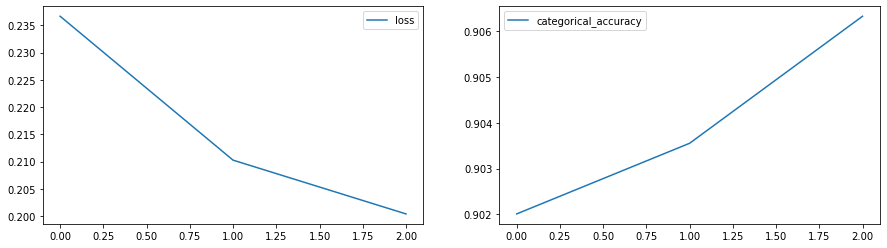

In [213]:
plot(model_history)

# Making a Prediction

In [219]:
val_model = tf.keras.models.load_model('xray_model__2020-11-0803_01_24.496480/model-00003-0.91399-0.93750.h5')

effusion image : ./CXR_data\effusion\00006592_000.png


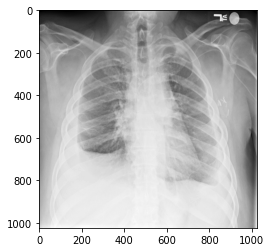

In [220]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)

print('effusion image :',effusion[0])
effusion = io.imread(effusion[0])
plt.imshow(effusion,cmap='gray')

In [221]:
#img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
img = preprocess_img(effusion[:, :,np.newaxis], 'validation')
img=np.repeat(img[...,],3,-1)
pred=val_model.predict(img[np.newaxis,:])
print('prediction is:',pred)
if pred[0][0]==1:
    print('effusion')
else:
    print('normal')


prediction is: [[1. 0.]]
effusion


In [222]:
!pip freeze > requirements.txt